<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/DFU_using_Deep_Learning_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Πτυχιακή Εργασία

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [16]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os

# Define dataset path (adjust if needed)
dataset_path = "/content/drive/MyDrive/DFU/Original Images"
trainset_path = "/content/drive/MyDrive/DFU/Patches"
testset_path = "/content/drive/MyDrive/DFU/TestSet"

# List categories (folders)
images = os.listdir(dataset_path)

In [38]:
!pip install keras

In [18]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

## Data Exploration

### Class Distribution

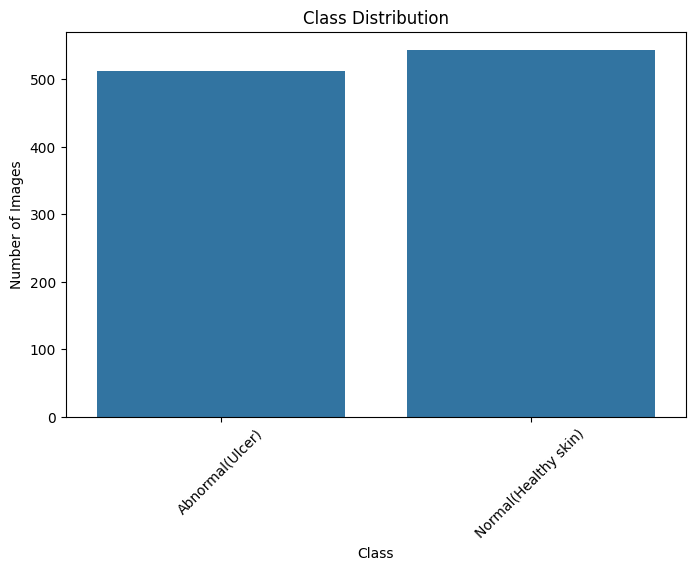

In [19]:
# Count images per class
class_counts = {category: len(os.listdir(os.path.join(trainset_path, category))) for category in os.listdir(trainset_path)}

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


### Average Images

In [20]:
def compute_average_image(image_dir, img_size=(224, 224)):
    all_images = []
    for file_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(img_size)
                all_images.append(np.array(img, dtype=np.float32))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if all_images:
        mean_image = np.mean(all_images, axis=0).astype(np.uint8)
        return mean_image
    else:
        print(f"No images found in {image_dir}.")
        return None


In [21]:
# Compute average image for healthy skin patches
average_healthy = compute_average_image(trainset_path + "/Normal(Healthy skin)")

# Compute average image for ulcerated skin patches
average_ulcer = compute_average_image(trainset_path + "/Abnormal(Ulcer)")

#### Visualizing Averages of the Dataset and the Train Set

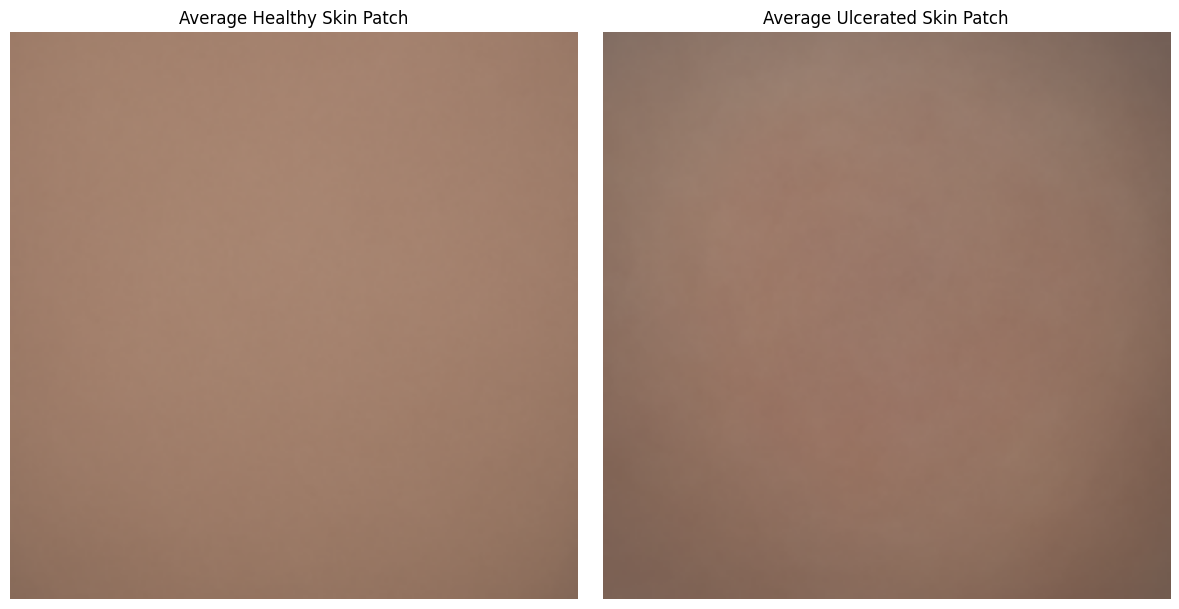

In [22]:
# Plotting the average images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

if average_healthy is not None:
    axes[0].imshow(average_healthy)
    axes[0].set_title("Average Healthy Skin Patch")
    axes[0].axis("off")
else:
    axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[0].set_title("Average Healthy Skin Patch")
    axes[0].axis("off")

if average_ulcer is not None:
    axes[1].imshow(average_ulcer)
    axes[1].set_title("Average Ulcerated Skin Patch")
    axes[1].axis("off")
else:
    axes[1].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[1].set_title("Average Ulcerated Skin Patch")
    axes[1].axis("off")

plt.tight_layout()
plt.show()



### Comparing sizes of the original dataset and the training set

In [33]:
path = os.listdir(dataset_path)[0]
test_img = cv2.imread(os.path.join(dataset_path, path))
print(test_img)

[[[254 255 250]
  [255 255 251]
  [255 255 252]
  ...
  [220 231 235]
  [214 228 234]
  [214 232 239]]

 [[255 255 251]
  [255 255 251]
  [255 255 252]
  ...
  [185 196 200]
  [190 206 212]
  [190 209 214]]

 [[255 255 252]
  [255 255 252]
  [255 255 252]
  ...
  [180 191 195]
  [180 197 200]
  [179 200 202]]

 ...

 [[215 249 248]
  [162 199 197]
  [151 191 189]
  ...
  [ 82 108 108]
  [ 80 111 104]
  [ 78 112 102]]

 [[212 249 245]
  [160 200 195]
  [149 193 187]
  ...
  [ 96 123 120]
  [ 88 119 110]
  [ 85 119 108]]

 [[207 248 241]
  [152 194 187]
  [147 191 184]
  ...
  [ 97 124 121]
  [ 92 123 114]
  [ 92 125 111]]]


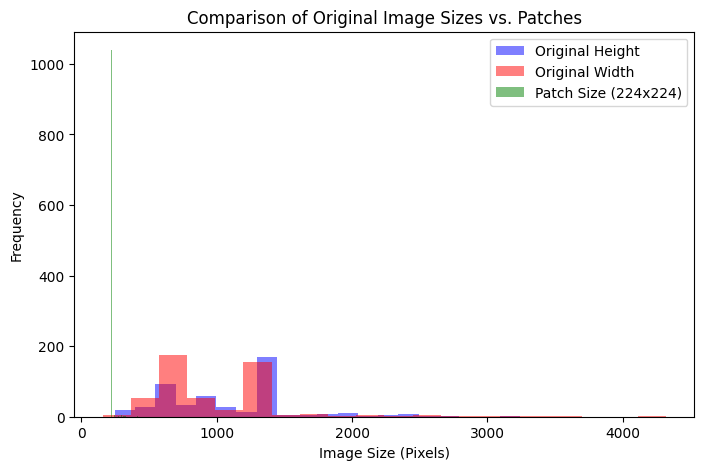

In [23]:
# Collect sizes
original_sizes = []
patch_sizes = []

for file in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, file))
    if img is not None:
        original_sizes.append(img.shape[:2])  # Height, Width

for category in ["Normal(Healthy skin)", "Abnormal(Ulcer)"]:
    category_path = os.path.join(trainset_path, category)
    for file in os.listdir(category_path):
        img = cv2.imread(os.path.join(category_path, file))
        if img is not None:
            patch_sizes.append(img.shape[:2])  # Height, Width

# Convert to NumPy arrays
original_sizes = np.array(original_sizes)
patch_sizes = np.array(patch_sizes)

# Plot size distributions
plt.figure(figsize=(8, 5))
plt.hist(original_sizes[:, 0], bins=20, alpha=0.5, label="Original Height", color="blue")
plt.hist(original_sizes[:, 1], bins=20, alpha=0.5, label="Original Width", color="red")
plt.hist(patch_sizes[:, 0], bins=20, alpha=0.5, label="Patch Size (224x224)", color="green")
plt.xlabel("Image Size (Pixels)")
plt.ylabel("Frequency")
plt.title("Comparison of Original Image Sizes vs. Patches")
plt.legend()
plt.show()


## Data Preprocessing

#### Reading Dataset using Tensoflow

In [25]:
# Load dataset
batch_size = 32
img_size = (224, 224)  # Resize images to 224x224

train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainset_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

# Get class names
class_names = train_dataset.class_names

Found 1055 files belonging to 2 classes.


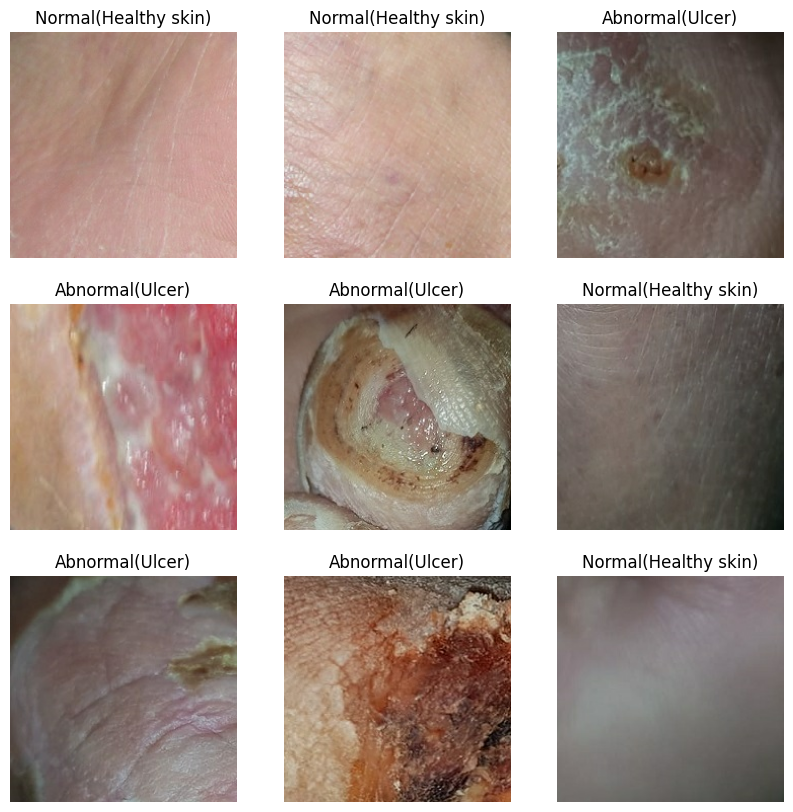

In [ ]:
# Get a batch of images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Normalize Images (Divide Pixel values with 255)

In [42]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#### Data Augmentation

In [46]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    # Add other augmentation layers as needed
])

In [48]:
from keras import models

model = models.Sequential([
    normalization_layer,
    data_augmentation,
    # Add your model layers here
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # ...
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Adjust based on your classification task
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use 'sparse_categorical_crossentropy' for multi-class
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_dataset,
    epochs=10,
    # validation_data=validation_dataset  # Include if you have a validation set
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5018 - loss: 104.8112
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4982 - loss: 4.7005
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4956 - loss: 0.8941
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4983 - loss: 0.9198
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4733 - loss: 0.7153
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5348 - loss: 0.6959
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5139 - loss: 0.6932
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5204 - loss: 0.7418
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5200 - loss: 0.6928
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5122 - loss: 0.6934
